# Population stratification analysis UAE + HGDP

In [2]:
import pandas as pd
from collections import Counter
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (16,10)
%matplotlib qt
import matplotlib.pyplot as plt

In [3]:
hgdp = pd.read_csv("HGDPid_populations.csv", sep=',', index_col='Id')
hgdp.head(3)

,Sex,population,Geographic_origin,Region,Pop7Groups
Id,,,,,
HGDP01405,M,Bantu_N.E.,Kenya,Subsaharian_Africa,Africa
HGDP01406,M,Bantu_N.E.,Kenya,Subsaharian_Africa,Africa
HGDP01408,M,Bantu_N.E.,Kenya,Subsaharian_Africa,Africa


In [4]:
## Metadata UAE
md = pd.read_csv('metaUAE_HGDP.csv', index_col='Id')
md.head(3)

,fid,ContPop,pob
Id,,,
12551,1,UAE,oman
120001,2,UAE,dubai
HGDP00448,3,Subsahara,NaN


## Cluster Analysis
Using plink's IBS statistics, yields a distance matrix.
Cluster distance measures average distances for predefined clusters, such as Place of birth for emiratis or HGDP populations.

In [5]:
import numpy as np
from scipy.spatial.distance import squareform

## heterogeneity
def clusterDistance(cluster1, cluster2, DM):
    return DM.loc[cluster1][cluster2].values.mean()

## separation
def withinClusterDistance(cluster, DM):
    return squareform(DM.loc[cluster][cluster]).mean()

def preFilter(clustering, prefilter):
    pass

def dunn(clustering, DM, prefilter=None):
    if prefilter: clustering = preFilter(clustering, prefilter)
    clusters = len(clustering)
    if clusters == 1:
        return withinClusterDistance(clustering[0], DM)                                                                                                
    maxIntra = max([withinClusterDistance(c, DM) for c in clustering])
    minInter = np.inf # clusterDistance(clustering[0], clustering[0], DM)                                           
    for cl1 in range(1, clusters):
        for cl2 in range(cl1):
            minInter = min(clusterDistance(clustering[cl1], clustering[cl2], DM), minInter)
    return minInter, maxIntra 

def compactness(cluster, clustering, DM):
    homogeneity = withinClusterDistance(cluster, DM)
    separation = [clusterDistance(cluster, otherCluster, DM) for otherCluster in clustering if not otherCluster is \
cluster]
    ## aka between cluster                                                                                          
    return [np.mean(separation)/homogeneity, np.mean(separation), homogeneity]

## Clustering Analysis: Dunn Index

In [6]:
def allDunnCI(clusterTable, dm):
    dunnAll = []
    nrClustersAll = []
    for clusterCol in clusterTable.columns.values[-30:-1]: # alternative clusterings: range(2, len(dm)+2):                                                                                                            
        clusterCounter = Counter(clusterTable[clusterCol])                                                                                                                                                           
        nrClusters = len(clusterCounter) #len(dm)-clusterCol+1                                                                                                                                                   
        nrClustersAll.append(nrClusters)
        if nrClusters > 1:                                                                                                                                                                                       
            clustering = [clusterTable[clusterTable[clusterCol]==i].index for i in clusterCounter.keys()] 
            #print(len(clustering))
            dunnCI = dunn(clustering, dm)
            dunnAll.append(dunnCI)
            ## mean Compactness:                                                                                                                                                                                 
            #print(clusterCol, len(clusterCounter))                                                                                                                                                               
            #print('Dunn: ', dunnCI) 
        else:
            dunnAll.append(1)
    return dunnAll #, nrClustersAll

In [199]:
a = set([1,2,3,4])
a.union(set([9]))

{1, 2, 3, 4, 9}

In [188]:
np.random.choice('a b c d e'.split(), 3, replace=False)

array(['c', 'b', 'a'], dtype='<U1')

In [10]:
def readClusterAnalysis(basename):
    cluster3 = pd.read_csv(f'{basename}.cluster3.gz', sep='\s+', header=None, index_col=1)
    #uae_hgdp1LD make plink's IBS similarity matrix to 1-IBS distance matrix
    dm = 1-pd.read_pickle(f'{basename}.pcl')
    for i in range(len(dm)): ## should have been in IBS matrix
        dm.iloc[i,i] = 0.0
    return dm, cluster3 


In [168]:
dmUAE, cluster3 = readClusterAnalysis('uae')
uaeOnlyDunn = allDunnCI(cluster3, dmUAE)

/Users/ahenschel/Applications/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
/Users/ahenschel/Applications/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
dm, cluster3 = readClusterAnalysis('uae_hgdp1LD')
uae_hgdpDunn = allDunnCI(cluster3, dm)

/Users/ahenschel/Applications/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
/Users/ahenschel/Applications/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
import itertools

populations = md.groupby('ContPop').groups

dunndata = []
for selection in set([tuple(sorted(i[:3])) for i in itertools.permutations(populations.keys())]):    
    clustering = [populations[p] for p in selection]
    minInter, maxIntra = dunn(clustering, dm)
    dunndata.append(('-'.join(selection), minInter, maxIntra, minInter/maxIntra))
dunnDF = pd.DataFrame(dunndata, columns='Pops,MinAmong,MaxWithin,Dunn'.split(','))
dunnDF.sort_values(by='Dunn')

,Pops,MinAmong,MaxWithin,Dunn
67,America-EastAsia-Subsahara,0.237298,0.251367,0.944028
48,Europe-MiddleEast-Subsahara,0.241204,0.251367,0.959570
38,America-EastAsia-NorthAfrica,0.237298,0.246292,0.963480
59,America-EastAsia-UAE,0.237298,0.246006,0.964602
44,CentralSouthAsia-Europe-Subsahara,0.243522,0.251367,0.968789
...,...,...,...,...
31,America-MiddleEast-Oceania,0.258970,0.241061,1.074294
53,America-NorthAfrica-Subsahara,0.275291,0.251367,1.095174
56,NorthAfrica-Oceania-Subsahara,0.275525,0.251367,1.096107
18,America-EastAsia-Oceania,0.237298,0.214690,1.105303


In [8]:
import itertools


populations = md.groupby('ContPop').groups
#set([i[:3] for i in itertools.permutations(populations.keys())])


In [170]:
cluster3hgdp = cluster3[cluster3.index.str.startswith('HGDP')]
hgdpDunn = allDunnCI(cluster3hgdp, dm)

/Users/ahenschel/Applications/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.


In [171]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(uaeOnlyDunn[:-1], label='UAE', ls='-')
ax.plot(uae_hgdpDunn[:-1], label='UAE+HGDP', ls='-')
ax.plot(hgdpDunn[:-1], label='HGDP', ls='-')
plt.legend(loc=2)
plt.show()

In [89]:
def heterogeneity(populations, dm1):
    clustering = populations.values()
    clusterData = [compactness(idx, clustering, dm1) for pop, idx in populations.items()]
    clusterDF = pd.DataFrame(clusterData, columns='sep/het separation heterogeneity'.split(), index=populations.keys())
    clusterDF['PopSize'] = list(map(len, clustering))
    return clusterDF.sort_values(by='heterogeneity', ascending=False)

In [90]:
def makePopDM(populations, selfsim='within'):                   
    popDM = pd.DataFrame(np.zeros((len(populations), len(populations))), columns=populations, index=populations)

    for pop1, pop1idx in populations.items():
        for pop2, pop2idx in populations.items():
            if pop1 == pop2:
                if selfsim == 0: d = 0
                else:
                    d = withinClusterDistance(pop1idx, dm1)
            else:
                d = clusterDistance(pop1idx, pop2idx, dm1)
            popDM.loc[pop1,pop2] = d
    return popDM

In [62]:
## helper functions for plotting color coded distance matrices with values
def show_values(pc, fmt="%.4f", **kw):
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)
def showMatrix(F):
    c = plt.pcolor(F, edgecolors='white', cmap='RdBu')
 
    plt.xticks(np.arange(0.5, len(F.columns), 1), F.columns, rotation=90)  
    plt.yticks(np.arange(0.5, len(F.index), 1), F.index)
    show_values(c)
    plt.colorbar(c)


## UAE ranks last in separation/heterogeneity, 3rd in heterogeneity
On the other hand, UAE has the lowest separation to heterogeneity ratio, indicating low clustering with regard to HGDP populations. The UAE thus exhibits higher diversity (in terms of IBS distances) than East Asia, Europe, America and Oceania (as per HGDP sampling).

In [72]:
## Continental populations + UAE
import copy
def downsample(populations, minVal="smallest"): ## minVal can be string or int!
    pops = copy.deepcopy(populations)
    if minVal=='smallest':
        minVal = min(map(len, pops.values()))
    popsDown = {}    
    for pop, popIdcs in pops.items():
        mv = min(minVal, len(popIdcs))
        popsDown[pop] = np.random.choice(popIdcs, mv, replace=False) #popIdcs[:minVal] ## this also works should    
    return popsDown


In [73]:
populations = md.groupby('ContPop').groups
#populations = downsample(populations, 100) ## try downsampling, impact is small
print(list(map(len,populations.values())))
#d = heterogeneity(populations, dm1)
#d.to_csv('sepHet.csv')

[108, 207, 235, 160, 146, 30, 36, 121, 1000]


In [82]:
sepHet = []
sep = []
het = []
for i in range(100):
    populations_ = downsample(populations, 50)
    #print(sorted(populations_['UAE'])[:10])
    hetDF = heterogeneity(populations_, dm1)
    sepHet.append(hetDF['sep/het'])
    sep.append(hetDF['separation'])
    het.append(hetDF['heterogeneity'])
     

In [83]:
df = pd.concat(sepHet, axis=1, sort=False)
dfHet = pd.concat(het, axis=1, sort=False)
dfSep = pd.concat(sep, axis=1, sort=False)
df['sep/het mean'] = df.mean(axis=1)
df['sep/het std'] = df.std(axis=1)
df['het mean'] = dfHet.mean(axis=1)
df['sep mean'] = dfSep.mean(axis=1)
df0 = df.iloc[:,-4:].sort_values(by='sep/het mean')
df0.to_csv('sephet2.csv')
df0
#= df.sort_values(by='mean')
#df

,sep/het mean,sep/het std,het mean,sep mean
UAE,1.054565,0.004772,0.246166,0.259591
CentralSouthAsia,1.067225,0.002745,0.241141,0.257350
NorthAfrica,1.075558,0.000610,0.246292,0.264902
MiddleEast,1.077917,0.003579,0.241032,0.259809
Europe,1.106219,0.001762,0.233787,0.258619
Subsahara,1.194249,0.007914,0.251074,0.299835
EastAsia,1.209640,0.003876,0.214681,0.259684
America,1.385649,0.012062,0.192412,0.266599
Oceania,1.391158,0.000801,0.193004,0.268499


In [84]:
fig = plt.figure()
fig, ax = plt.subplots()
xpos = np.arange(len(df))
ax.bar(xpos, df0['sep/het mean'], yerr=list(df0['sep/het std']), align='center', alpha=0.5, ecolor='k', capsize=10)
ax.set_xticks(xpos)
ax.set_xticklabels(df.index.values)
plt.tight_layout()
plt.show()

In [13]:
N = 1000

x1 = np.random.randn(N) 
y1 = np.random.randn(N) 

fig, ax = plt.subplots(nrows=1,ncols=1)

ax.scatter(x1,y1,color='hotpink')

H, xedges, yedges = np.histogram2d(x1,y1)
extent = [xedges[0],xedges[-1],yedges[0],yedges[-1]]
cset1 = ax.contour(H,extent=extent,levels=[10,20,30])



In [68]:
popDM1 = makePopDM(populations)
popDM1

,America,CentralSouthAsia,EastAsia,Europe,MiddleEast,NorthAfrica,Oceania,Subsahara,UAE
America,0.192485,0.255881,0.237298,0.261321,0.266761,0.275291,0.258970,0.311137,0.265939
CentralSouthAsia,0.255881,0.241174,0.248595,0.243522,0.246915,0.257182,0.260066,0.299350,0.247189
EastAsia,0.237298,0.248595,0.214690,0.256884,0.260564,0.267793,0.245334,0.301879,0.258936
Europe,0.261321,0.243522,0.256884,0.233762,0.241204,0.251332,0.266785,0.303050,0.244600
MiddleEast,0.266761,0.246915,0.260564,0.241204,0.241061,0.251643,0.269071,0.297362,0.244857
NorthAfrica,0.275291,0.257182,0.267793,0.251332,0.251643,0.246292,0.275525,0.286752,0.253580
Oceania,0.258970,0.260066,0.245334,0.266785,0.269071,0.275525,0.193004,0.304564,0.267519
Subsahara,0.311137,0.299350,0.301879,0.303050,0.297362,0.286752,0.304564,0.251367,0.293682
UAE,0.265939,0.247189,0.258936,0.244600,0.244857,0.253580,0.267519,0.293682,0.246006


In [69]:
import scipy.cluster.hierarchy as sch
Y = sch.linkage(popDM1.values, method='average')
Z = sch.dendrogram(Y, labels=popDM1.columns.values, leaf_rotation=90)

In [72]:
#showMatrix(popDM1)
showMatrix(popDM1.iloc[Z['leaves'],Z['leaves']])
#plt.savefig('popDM.svg', dpi=600) ## better to save from popout windowb

In [74]:
emirates0 = md.groupby('pob').groups
emirates = {emi:idx for emi, idx in emirates0.items() if len(idx)>30}
emirates = downsample(emirates, 50)
heterogeneity(emirates, dm1)

,sep/het,separation,heterogeneity,PopSize
sharjah,0.996585,0.247415,0.248263,50
abu_dhabi,1.000358,0.246067,0.245979,50
al_ain,1.003107,0.246167,0.245405,50
dubai,1.003937,0.245979,0.245014,50
al_fujairah,1.010922,0.246486,0.243823,33
rak,1.007342,0.245369,0.243581,50
yemen,1.015353,0.245562,0.241849,50


In [210]:
popDM2 = makePopDM(emirates)
popDM2

,abu_dhabi,al_ain,al_fujairah,dubai,rak,sharjah,yemen
abu_dhabi,0.244978,0.244987,0.246466,0.246687,0.244889,0.246603,0.244419
al_ain,0.244987,0.244423,0.246544,0.247043,0.245087,0.246918,0.243925
al_fujairah,0.246466,0.246544,0.243823,0.247223,0.245100,0.246891,0.246437
dubai,0.246687,0.247043,0.247223,0.247118,0.245875,0.247306,0.247062
rak,0.244889,0.245087,0.245100,0.245875,0.243787,0.245836,0.244946
sharjah,0.246603,0.246918,0.246891,0.247306,0.245836,0.246830,0.246863
yemen,0.244419,0.243925,0.246437,0.247062,0.244946,0.246863,0.242240


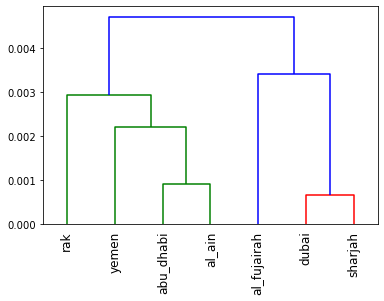

In [224]:
Y = sch.linkage(popDM2.values, method='average')
Z = sch.dendrogram(Y, labels=popDM2.columns.values, leaf_rotation=90)

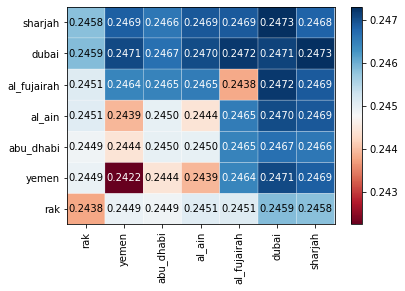

In [225]:
showMatrix(popDM2.iloc[Z['leaves'],Z['leaves']])

In [219]:
populations.update(emirates)
heterogeneity(populations, dm1)

,sep/het,separation,heterogeneity
Subsahara,1.180680,0.296784,0.251367
dubai,1.026014,0.253547,0.247118
sharjah,1.027891,0.253714,0.246830
NorthAfrica,1.053972,0.259585,0.246292
UAE,1.028805,0.253092,0.246006
abu_dhabi,1.032889,0.253035,0.244978
al_ain,1.036789,0.253415,0.244423
al_fujairah,1.040046,0.253587,0.243823
rak,1.035488,0.252438,0.243787
yemen,1.045713,0.253313,0.242240


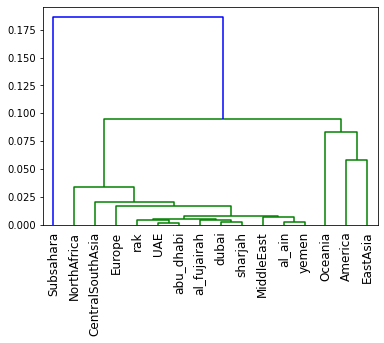

In [220]:
popDM3 = makePopDM(populations)
Y = sch.linkage(popDM3.values, method='average')
Z = sch.dendrogram(Y, labels=popDM3.columns.values, leaf_rotation=90)

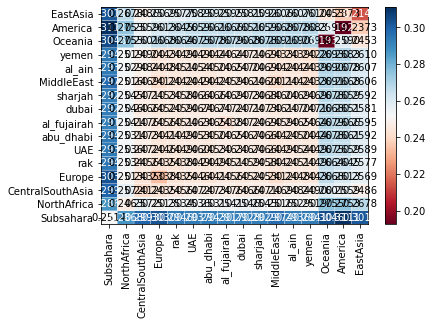

In [222]:
popDM3 = popDM3.iloc[Z['leaves'],Z['leaves']]
showMatrix(popDM3)

In [221]:
plt.show()

In [90]:
help(plt.pcolor)

Help on function pcolor in module matplotlib.pyplot:

pcolor(*args, alpha=None, norm=None, cmap=None, vmin=None, vmax=None, data=None, **kwargs)
    Create a pseudocolor plot with a non-regular rectangular grid.
    
    Call signature::
    
        pcolor([X, Y,] C, **kwargs)
    
    *X* and *Y* can be used to specify the corners of the quadrilaterals.
    
    .. hint::
    
        ``pcolor()`` can be very slow for large arrays. In most
        cases you should use the similar but much faster
        `~.Axes.pcolormesh` instead. See there for a discussion of the
        differences.
    
    Parameters
    ----------
    C : array-like
        A scalar 2-D array. The values will be color-mapped.
    
    X, Y : array-like, optional
        The coordinates of the quadrilateral corners. The quadrilateral
        for ``C[i, j]`` has corners at::
    
            (X[i+1, j], Y[i+1, j])           (X[i+1, j+1], Y[i+1, j+1])
                                  +---------+
                 